In [59]:
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import tqdm.auto as tqdm
from torch import nn
import math
from torch.distributions.multivariate_normal import MultivariateNormal

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [106]:
# def make_pos_grid(kernel_size: int, grid_at_end: bool = False) -> torch.Tensor:
#     positions = torch.arange(
#         -kernel_size // 2 + 1,
#         kernel_size // 2 + 1,
#     )
#     return (
#         torch.cartesian_prod(positions, positions)
#         .unsqueeze(1)  # Broadcast along out_channels
#         .unsqueeze(2)  # Broadcast along in_channels
#     ).movedim(0, -1 if grid_at_end else 0)
#
#
# make_pos_grid(3)

tensor([[[[-1, -1]]],


        [[[-1,  0]]],


        [[[-1,  1]]],


        [[[ 0, -1]]],


        [[[ 0,  0]]],


        [[[ 0,  1]]],


        [[[ 1, -1]]],


        [[[ 1,  0]]],


        [[[ 1,  1]]]])

In [7]:
# def plot_kernels(kernels: torch.Tensor, cut_zero=True, high_cut: float = 0.95) -> None:
#     dev_name = "(CPU)" if kernels.get_device() == -1 else "(CUDA)"
#     kernels = kernels.detach().cpu()
#     high = torch.quantile(kernels.view(-1), torch.tensor([high_cut])).cpu().item()
#     out_channels, in_channels, kernel_size, _ks = kernels.shape
#     fig, axss = plt.subplots(
#         out_channels, in_channels, sharex=True, sharey=True, layout="compressed"
#     )
#     if out_channels == 1:
#         axss = (axss,)
#     for o, axs in enumerate(axss):
#         if in_channels == 1:
#             axs = (axs,)
#         for i, ax in enumerate(axs):
#             ax: plt.Axes
#             sns.heatmap(
#                 kernels[o, i],
#                 vmin=0 if cut_zero else None,
#                 vmax=high,
#                 square=True,
#                 ax=ax,
#                 cbar=False,
#             )
#             ax.set_axis_off()
#             ax.set_title(f"Sum {kernels[o, i].sum():.2f}", fontsize=6)
#     plt.suptitle(f"Convolution kernels: {dev_name}\n (out-channels x in-channels)")
#     plt.show()

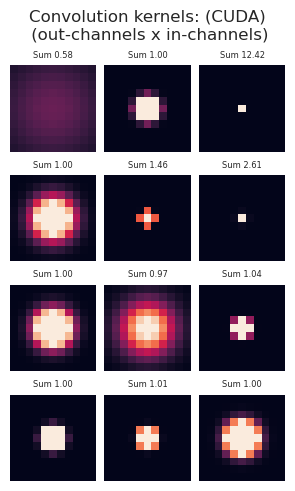

In [118]:
# class GaussKernelIso2D(nn.Module):
#     """A kernel that evaluates the isotropic N(x; 0, sI), for use in a linear convolution"""
#
#     pos_grid: torch.Tensor
#     std_param: torch.Tensor
#
#     def __init__(
#             self, in_channels: int, out_channels: int, kernel_size: int, init: str = "zero"
#     ):
#         super().__init__()
#         self.std_param = nn.Parameter(torch.empty((out_channels, in_channels)))
#         if init == "zero":
#             nn.init.zeros_(self.std_param)
#         elif init == "normal":
#             nn.init.normal_(self.std_param)
#         else:
#             raise ValueError(f"Invalid {init=}")
#         self.kernel_size = kernel_size
#         self.register_buffer("pos_grid", make_pos_grid(kernel_size))
#
#     def forward(self):
#         std = self.std_param.exp().unsqueeze(2).repeat((1, 1, 2))
#         dist = MultivariateNormal(
#             torch.zeros((2,), device=std.device), scale_tril=torch.diag_embed(std)
#         )
#         grid_probs = dist.log_prob(self.pos_grid).exp()
#         out_channels, in_channels = self.std_param.shape
#         assert grid_probs.shape == (
#             self.kernel_size * self.kernel_size,
#             out_channels,
#             in_channels,
#         ), f"Incorect {grid_probs.shape=}"
#         kernel = grid_probs.movedim(0, 2).reshape(
#             (out_channels, in_channels, self.kernel_size, self.kernel_size)
#         )
#         return kernel
#
#     def extra_repr(self):
#         out_channels, in_channels = self.std_param.shape
#         kernel_size = self.kernel_size
#         return f"{in_channels}, {out_channels}, {kernel_size=}"
#
#
# torch.manual_seed(0)
# plot_kernels(GaussKernelIso2D(3, 4, kernel_size=11, init="normal").to(device)())

In [119]:
# class LearnedCovs2D(nn.Module):
#     """A utility class that parameterises a series of 2D covariance matrices using std1, std2 and corr12"""
#
#     def __init__(
#             self, in_channels: int, out_channels: int, init: str = "zero"
#     ):
#         super().__init__()
#         self.std_params = nn.Parameter(torch.empty((2, out_channels, in_channels)))
#         self.corr_param = nn.Parameter(torch.empty((out_channels, in_channels)))
#         if init == "zero":
#             nn.init.zeros_(self.std_params)
#             nn.init.zeros_(self.corr_param)
#         elif init == "normal":
#             nn.init.normal_(self.std_params)
#             nn.init.normal_(self.corr_param)
#         else:
#             raise ValueError(f"Invalid {init=}")
#
#     def cholesky(self):
#         out_channels, in_channels = self.corr_param.shape
#
#         std = self.std_params.exp()
#         corr = self.corr_param.tanh()
#         l_cross = corr * std[1]
#
#         scale_tril = torch.zeros(
#             (out_channels, in_channels, 2, 2), device=std.device
#         )
#         scale_tril[:, :, 0, 0] = std[0]
#         scale_tril[:, :, 1, 0] = l_cross
#         scale_tril[:, :, 1, 1] = (std[1].square() - l_cross.square()).sqrt()
#         return scale_tril
#
#     def cov(self):
#         tril = self.cholesky()
#         return torch.einsum("oivL,oiVL->oivV", tril, tril)
#
#     def extra_repr(self):
#         out_channels, in_channels = self.corr_param.shape
#         kernel_size = self.kernel_size
#         return f"{in_channels}, {out_channels}, {kernel_size=}"

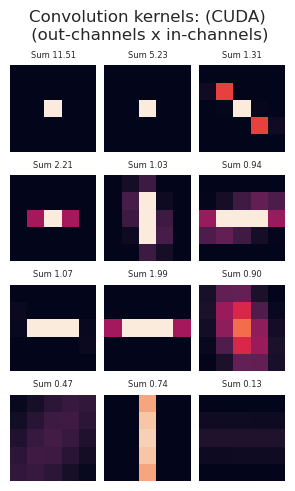

In [120]:
# class GaussKernelMulti2D(nn.Module):
#     """A kernel that evaluates the multivariate N(x; 0, S), for use in a linear convolution"""
#
#     pos_grid: torch.Tensor
#     means: torch.Tensor
#
#     def __init__(
#             self, in_channels: int, out_channels: int, kernel_size: int, init: str = "zero"
#     ):
#         super().__init__()
#         self.covs = LearnedCovs2D(in_channels, out_channels, init)
#         self.kernel_size = kernel_size
#         self.out_channels = out_channels
#         self.in_channels = in_channels
#         self.register_buffer("pos_grid", make_pos_grid(kernel_size))
#         self.register_buffer("means", torch.zeros((2,)))
#
#     def forward(self):
#         tril = self.covs.cholesky()
#         dist = MultivariateNormal(
#             loc=self.means,
#             scale_tril=tril,
#         )
#         grid_probs = dist.log_prob(self.pos_grid).exp()
#         assert grid_probs.shape == (
#             self.kernel_size * self.kernel_size,
#             self.out_channels,
#             self.in_channels,
#         ), f"Incorect {grid_probs.shape=}"
#         kernel = grid_probs.movedim(0, 2).reshape(
#             (
#                 self.out_channels,
#                 self.in_channels,
#                 self.kernel_size,
#                 self.kernel_size,
#             )
#         )
#         return kernel
#
#     def extra_repr(self):
#         kernel_size = self.kernel_size
#         return f"{self.in_channels}, {self.out_channels}, {kernel_size=}"
#
#
# torch.manual_seed(1)
# plot_kernels(GaussKernelMulti2D(3, 4, 5, init="normal").to(device)())

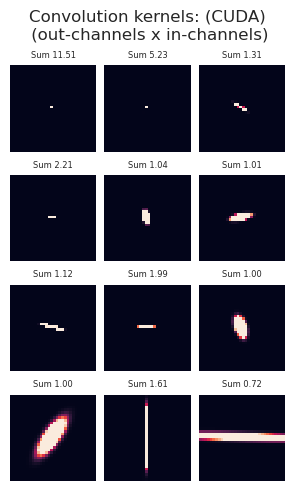

In [41]:
# torch.manual_seed(1)
# plot_kernels(GaussKernelMulti2D(3, 4, 32, init="normal").to(device)(), high_cut=0.98)

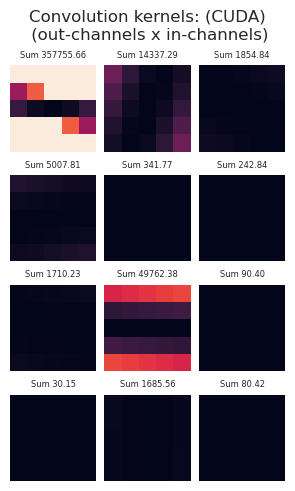

In [122]:
# class QuadraticKernelMulti2D(nn.Module):
#     """A kernel that evaluates xT S^-1 x, for use in a tropical convolution"""
#     pos_grid: torch.Tensor
#
#     def __init__(
#             self, in_channels: int, out_channels: int, kernel_size: int, init: str = "zero"
#     ):
#         super().__init__()
#         self.covs = LearnedCovs2D(in_channels, out_channels, init)
#         self.kernel_size = kernel_size
#         self.out_channels = out_channels
#         self.in_channels = in_channels
#         self.register_buffer("pos_grid", make_pos_grid(kernel_size, grid_at_end=True))
#
#     def forward(self):
#         # [o, i, 2, k*k]
#         bs = torch.linalg.solve_triangular(self.covs.cholesky(), self.pos_grid, upper=False)
#         dists = bs.pow(2).sum(-2).reshape((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
#         return dists
#
#     def extra_repr(self):
#         kernel_size = self.kernel_size
#         return f"{self.in_channels}, {self.out_channels}, {kernel_size=}"
#
#
# torch.manual_seed(1)
# plot_kernels(QuadraticKernelMulti2D(3, 4, 5, init="normal").to(device)())

In [11]:
class LearnedKernel(nn.Module):
    def __init__(
            self, in_channels: int, out_channels: int, kernel_size: int, init: str = "zero"
    ):
        super().__init__()
        self.kernel = nn.Parameter(
            torch.empty(out_channels, in_channels, kernel_size, kernel_size)
        )
        if init == "zero":
            nn.init.zeros_(self.kernel)
        elif init == "normal":
            nn.init.normal_(self.kernel)
        else:
            raise ValueError(f"Invalid {init=}")

    def forward(self):
        return self.kernel

In [131]:
# class LinearConv2D(nn.Module):
#     """A convolution in the linear field"""
#     forward = staticmethod(nn.functional.conv2d)

In [198]:
# class TropicalConv2D(nn.Module):
#     """A convolution in the tropical-max or tropical-min subfield, also known as dilation or erosion"""
#
#     def __init__(self, *, is_max: bool, softmax_temp: float | None = None):
#         super().__init__()
#         self.is_max = is_max
#         self.softmax_temp = softmax_temp
#
#     @staticmethod
#     def _output_size(input_size: int, kernel_size: int, dilation: int, padding: int, stride: int):
#         return math.floor((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)
#
#     def forward(self, x: torch.Tensor, kernel: torch.Tensor,
#                 dilation: int = 1, padding: int = 0, stride: int = 1):
#         assert len(kernel.shape) == 4, f"Kernel shape seems off: {kernel.shape=}"
#         out_channels, in_channels, kernel_size, _ks = kernel.shape
#         assert kernel_size == _ks
#         xdims = len(x.shape)
#         if xdims == 3:
#             x = x.unsqueeze(0)
#         elif xdims < 3 or xdims > 5:
#             raise ValueError(f"Input shape seems off: {x.shape=}")
#         inp_batch, _in_ch, inp_x, inp_y = x.shape
#         assert in_channels == _in_ch
#         new_x = self._output_size(inp_x, kernel_size, dilation, padding, stride)
#         new_y = self._output_size(inp_y, kernel_size, dilation, padding, stride)
#         assert new_x > 0 and new_y > 0
#
#         stencils = nn.functional.unfold(x, (kernel_size, kernel_size), dilation, padding, stride).unsqueeze(1)
#         weights = kernel.view(1, out_channels, in_channels * kernel_size * kernel_size, 1)
#         assert weights.shape[2] == stencils.shape[2]
#
#         if self.is_max:
#             # [batch, o, i*k*k, y'*x']
#             vals = stencils - weights
#             if self.softmax_temp is None:
#                 reduced = torch.max(vals, dim=2).values
#             else:
#                 # I looked at using logsumexp here, but the limits in temperature of logsumexp are
#                 # t=0 gives val=inf, t=inf gives val=max
#                 # while the limits in temperature of softmax * x are
#                 # t=0 gives val=mean, t=inf gives val=max
#
#                 # dot product
#                 reduced = torch.einsum("boKs,boKs->bos", torch.softmax(vals / self.softmax_temp, dim=2), vals)
#         else:
#             vals = stencils + weights
#             if self.softmax_temp is None:
#                 reduced = torch.min(vals, dim=2).values
#             else:
#                 reduced = torch.einsum("boKs,boKs->bos", torch.softmin(vals / self.softmax_temp, dim=2), vals)
#
#         assert reduced.shape == (
#             x.shape[0], out_channels,
#             new_y * new_x), f"{reduced.shape=} != {(x.shape[0], out_channels, new_y * new_x)=}"
#         res = reduced.reshape(-1, out_channels, new_y, new_x)
#         if xdims == 3:
#             res = res.squeeze(0)
#         return res


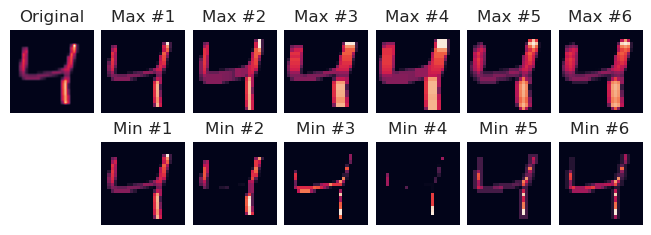

In [212]:
def try_tropical_conv(kernels: torch.Tensor | list, num_img: int = 0):
    kernels = torch.as_tensor(kernels, dtype=torch.float32)
    img = torch.as_tensor(torchvision.datasets.MNIST(root="./data", download=True).data[num_img])
    img = nn.functional.normalize(img.float())
    out_channels = kernels.shape[0]
    _, ((ax_original, *ax_maxs), (ax_unused, *ax_mins)) = plt.subplots(2, 1 + out_channels, layout="compressed")
    ax_original.set_axis_off()
    ax_unused.set_axis_off()
    ax_original.imshow(img)
    ax_original.set_title("Original")
    conv_max = TropicalConv2D(is_max=True)(img.unsqueeze(0), kernels)
    for i, (ax, img_channel) in enumerate(zip(ax_maxs, conv_max, strict=True), 1):
        ax.set_axis_off()
        ax.imshow(img_channel)
        ax.set_title(f"Max #{i}")
    conv_min = TropicalConv2D(is_max=False)(img.unsqueeze(0), kernels)
    for i, (ax, img_channel) in enumerate(zip(ax_mins, conv_min, strict=True), 1):
        ax.set_axis_off()
        ax.imshow(img_channel)
        ax.set_title(f"Min #{i}")


INF = float("inf")
try_tropical_conv([
    [[[INF, INF, INF], [INF, 0, INF], [INF, INF, INF]]],  # 1: Does nothing
    [[[INF, 0, INF], [INF, 0, INF], [INF, 0, INF]]],  # 2: Vertical max
    [[[INF, INF, INF], [0, 0, 0], [INF, INF, INF]]],  # 3: Horizontal max
    [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]],  # 4: 3x3 max
    [[[0.4, 0.1, 0.4], [0.1, 0, 0.1], [0.4, 0.1, 0.4]]],  # 5: small quadratic max, isotropic
    [[[0.5, 0.2, 0.5], [0.05, 0, 0.05], [0.5, 0.2, 0.5]]],  # 5: small quadratic max, wide horizontally
], num_img=2)

In [13]:
class GenericConv2D(nn.Module):
    def __init__(
            self,
            kernel: nn.Module,
            conv: nn.Module,
    ):
        super().__init__()
        self.kernel = kernel
        self.conv = conv

    def forward(self, x):
        return self.conv(x, self.kernel())

In [14]:
class SimpleConvClassifier(nn.Module):
    def __init__(
            self,
            conv_type: Callable[[int, int, int], nn.Module],
            kernel_sizes: Iterable[int],
            planes: Iterable[int],
            img_channels: int = 3,
            img_dims: int = 2,
            activate_first: bool = True,
            *,
            out_classes: int,
    ):
        super().__init__()
        params = chain(((-1, img_channels),), zip(kernel_sizes, planes, strict=True))
        convs = []
        activate = activate_first
        for (_, in_channels), (kernel_size, out_channels) in pairwise(params):
            convs.append(conv_type(in_channels, out_channels, kernel_size))
            if activate:
                convs.append(nn.ReLU6())
            activate = True

        self.convs = nn.Sequential(*convs)
        self.lin = nn.LazyLinear(out_classes)
        self.img_dims = img_dims

    def forward(self, x: torch.Tensor) -> torch.distributions.Categorical:
        x = self.convs(x)
        x = x.mean([img_dim for img_dim in range(-self.img_dims, 0)])
        x = self.lin(x)
        x = torch.distributions.Categorical(logits=x)
        return x


test_cls = SimpleConvClassifier(nn.Conv2d, (7, 3, 5), (10, 20, 60), out_classes=10).to(
    device
)
test_cat = test_cls(torch.ones((5, 3, 50, 50), device=device))
print(test_cls)
print(test_cat)
test_cat.log_prob(torch.tensor([1, 2, 3, 4, 5], device=device))

SimpleConvClassifier(
  (convs): Sequential(
    (0): Conv2d(3, 10, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU6()
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU6()
    (4): Conv2d(20, 60, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU6()
  )
  (lin): Linear(in_features=60, out_features=10, bias=True)
)
Categorical(logits: torch.Size([5, 10]))


tensor([-2.3917, -2.2345, -2.3500, -2.2015, -2.3160], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [15]:
def _generic_conv(
        kernel_cls: type[nn.Module], conv_cls: type[nn.Module], init: str = "normal"
):
    def _new(in_channels, out_channels, kernel_size):
        return GenericConv2D(
            kernel=kernel_cls(in_channels, out_channels, kernel_size, init=init),
            conv=conv_cls(),
        )

    return _new

In [16]:
for kernel_type in (LearnedKernel, GaussKernelIso2D, GaussKernelMulti2D):
    test_cls = SimpleConvClassifier(
        _generic_conv(kernel_type, LinearConv2D), (7, 3, 5), (10, 20, 60), out_classes=10
    ).to(device)
    test_cat = test_cls(torch.ones((5, 3, 50, 50), device=device))
    print(test_cls)
    print(test_cat)
    print(test_cat.log_prob(torch.tensor([1, 2, 3, 4, 5], device=device)))
    print(sum(p.numel() for p in test_cls.parameters()), "parameters")
    print("\n===\n")

SimpleConvClassifier(
  (convs): Sequential(
    (0): GenericConv2D(
      (kernel): LearnedKernel()
      (conv): LinearConv()
    )
    (1): ReLU6()
    (2): GenericConv2D(
      (kernel): LearnedKernel()
      (conv): LinearConv()
    )
    (3): ReLU6()
    (4): GenericConv2D(
      (kernel): LearnedKernel()
      (conv): LinearConv()
    )
    (5): ReLU6()
  )
  (lin): Linear(in_features=60, out_features=10, bias=True)
)
Categorical(logits: torch.Size([5, 10]))
tensor([-4.4583, -3.2102, -3.8522, -7.8212, -5.9729], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
33880 parameters

===

SimpleConvClassifier(
  (convs): Sequential(
    (0): GenericConv2D(
      (kernel): GaussKernelIso(3, 10, kernel_size=7)
      (conv): LinearConv()
    )
    (1): ReLU6()
    (2): GenericConv2D(
      (kernel): GaussKernelIso(10, 20, kernel_size=3)
      (conv): LinearConv()
    )
    (3): ReLU6()
    (4): GenericConv2D(
      (kernel): GaussKernelIso(20, 60, kernel_size=5)
      (conv): LinearCon

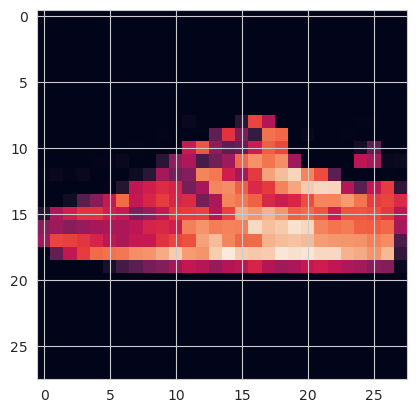

In [17]:
batch_size = 512
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_data = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)
plt.imshow(next(iter(train_loader))[0][batch_size - 1, 0])

In [18]:
def train_model(model: nn.Module, epcohs: int = 1, lr=1e-3):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bar = tqdm.trange(epcohs, unit="epochs")
    model = model.to(device)
    losses = []
    for _epoch in bar:
        for imgs, ys in train_loader:
            imgs, ys = imgs.to(device), ys.to(device)
            opt.zero_grad()
            pred_dist: torch.distributions.Categorical = model(imgs)
            nll = -pred_dist.log_prob(ys).mean()
            nll.backward()
            opt.step()
            bar.set_postfix(loss=nll.item())
            losses.append(nll.item())
    return losses

  0%|          | 0/10 [00:00<?, ?epochs/s]

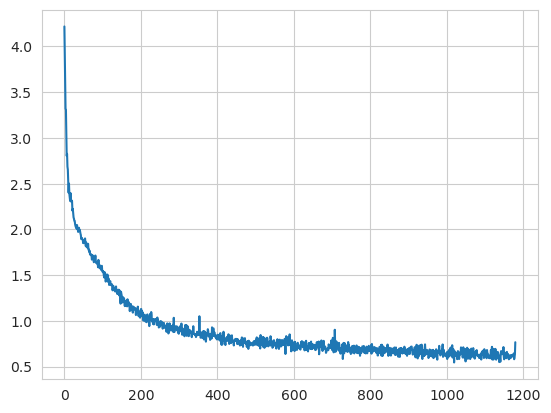

In [19]:
torch.manual_seed(0)
test_cls = SimpleConvClassifier(
    _generic_conv(LearnedKernel, LinearConv2D),
    (7, 3, 5),
    (10, 20, 60),
    out_classes=10,
    img_channels=1,
)
hist = train_model(test_cls, epcohs=10)
plt.plot(hist)

In [20]:
test_data = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

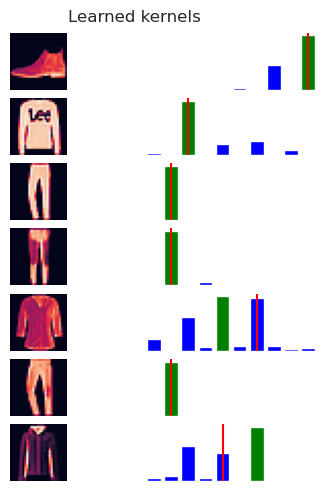

In [21]:
@torch.no_grad()
def plot_predictions(model: nn.Module, num_preds: int = 7, name: str = None):
    model.eval()
    assert num_preds <= batch_size
    imgs, ys = next(iter(test_loader))
    imgs, ys = imgs[:num_preds].to(device), ys[:num_preds].to(device)
    probs = model.to(device)(imgs).probs.cpu()
    fig, axs = plt.subplots(len(probs), 2, layout="compressed")
    for img, y, prob, (img_ax, prob_ax) in zip(
            imgs.cpu(), ys.cpu(), probs, axs, strict=True
    ):
        prob_ax: plt.Axes
        img_ax.imshow(img[0])
        prob_ax.bar(
            range(10),
            prob,
            color=["green" if i == prob.argmax().item() else "blue" for i in range(10)],
        )
        prob_ax.axvline(y, color="red")
        img_ax.set_axis_off()
        prob_ax.set_axis_off()
    if name is not None:
        fig.suptitle(name)
    plt.show()


plot_predictions(test_cls, name="Learned kernels")

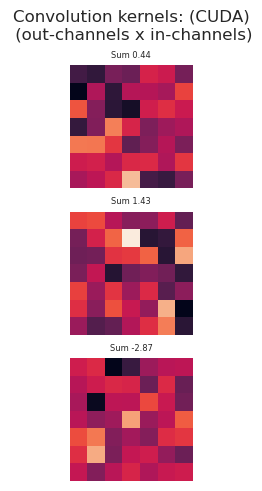

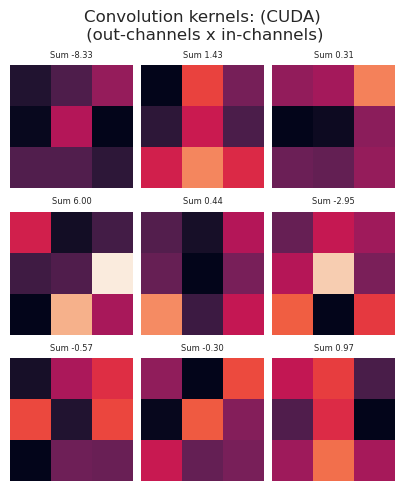

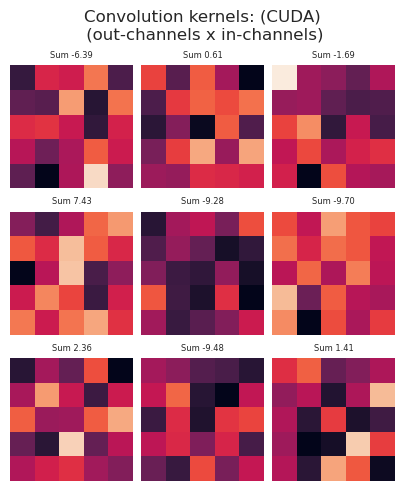

In [22]:
def plot_model_kernels(model: nn.Module, max_channels: int = 3, cut_zero=True):
    for conv in model.convs:
        if isinstance(conv, GenericConv2D):
            plot_kernels(
                conv.kernel()[:max_channels, :max_channels],
                cut_zero=cut_zero,
                high_cut=1.0,
            )


plot_model_kernels(test_cls, cut_zero=False)

In [23]:
@torch.no_grad()
def eval_accuracy(model: nn.Module, name: str = None):
    model.eval()
    model = model.to(device)
    if name is not None:
        print(f"Model: {name}")
    for data_name, data_loader in (("train", train_loader), ("test", test_loader)):
        top1 = 0
        top5 = 0
        count = 0
        for imgs, ys in data_loader:
            imgs, ys = imgs.to(device), ys.cpu()
            pred_labels: torch.distributions.Categorical = model(imgs)
            argsort_preds = pred_labels.probs.cpu().argsort(axis=1, descending=True)
            ranking = torch.empty_like(argsort_preds)
            ranking[torch.arange(len(ys)).unsqueeze(1), argsort_preds] = torch.arange(
                10
            ).unsqueeze(0)
            nth_rank = ranking[torch.arange(len(ys)), ys]
            count += len(nth_rank)
            top1 += (nth_rank < 1).sum().item()
            top5 += (nth_rank < 5).sum().item()

        print(f"Top1 ({data_name}):, {top1 / count:.1%}")
        print(f"Top5 ({data_name}):, {top5 / count:.1%}")


eval_accuracy(test_cls, name="Learned kernels")

Model: Learned kernels
Top1 (train):, 77.3%
Top5 (train):, 99.4%
Top1 (test):, 77.0%
Top5 (test):, 99.3%


In [24]:
def num_params(model: nn.Module):
    print(sum(p.numel() for p in model.parameters()), "parameters")


num_params(test_cls)

32900 parameters


  0%|          | 0/5 [00:00<?, ?epochs/s]

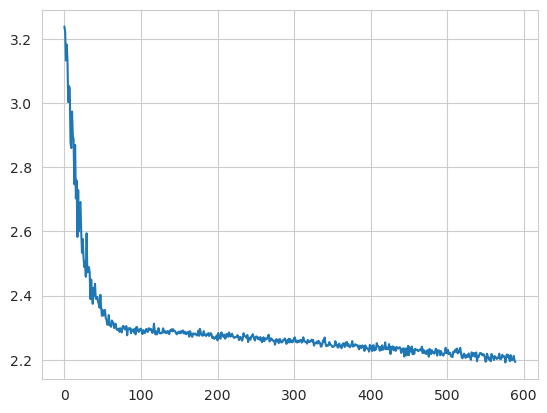

In [25]:
torch.manual_seed(0)
cls_iso = SimpleConvClassifier(
    _generic_conv(GaussKernelIso2D, LinearConv2D),
    (7, 3, 5),
    (50, 10, 10),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_iso, epcohs=5)
plt.plot(hist)

Top1 (train):, 17.4%
Top5 (train):, 70.0%
Top1 (test):, 17.5%
Top5 (test):, 68.9%
760 parameters


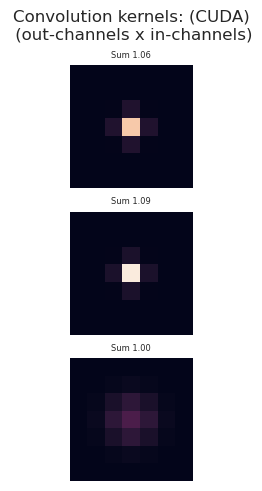

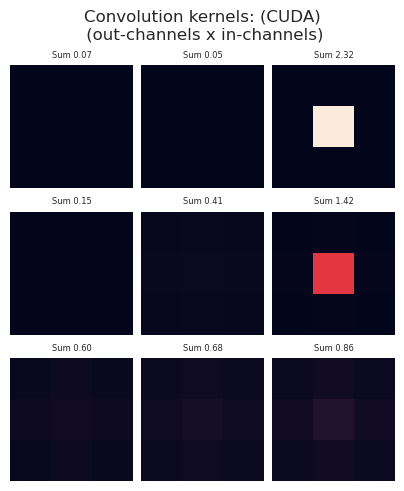

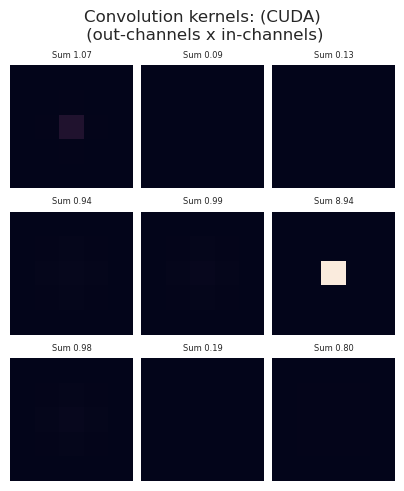

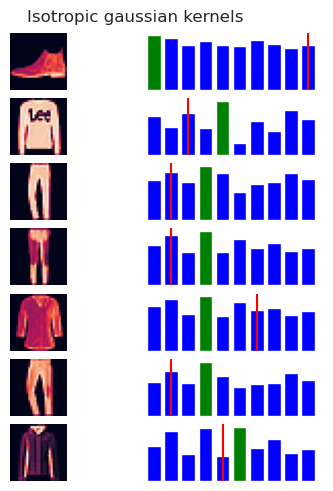

In [26]:
eval_accuracy(cls_iso)
num_params(cls_iso)
plot_model_kernels(cls_iso)
plot_predictions(cls_iso, name="Isotropic gaussian kernels")

  0%|          | 0/5 [00:00<?, ?epochs/s]

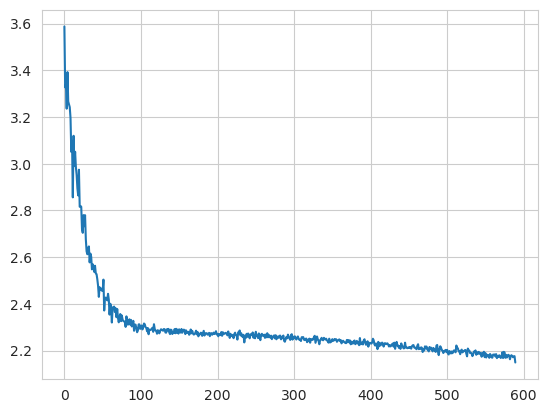

In [27]:
torch.manual_seed(0)
cls_multi = SimpleConvClassifier(
    _generic_conv(GaussKernelMulti2D, LinearConv2D),
    (10, 3, 5),
    (8, 8, 8),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_multi, epcohs=5)
plt.plot(hist)

Top1 (train):, 21.9%
Top5 (train):, 69.0%
Top1 (test):, 22.2%
Top5 (test):, 68.5%
498 parameters


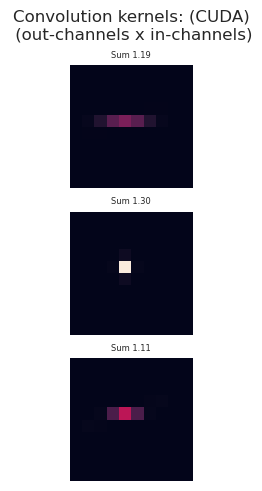

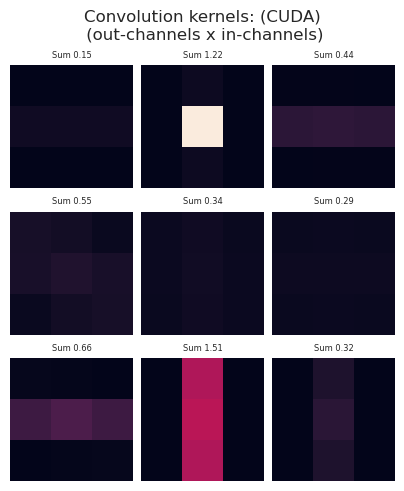

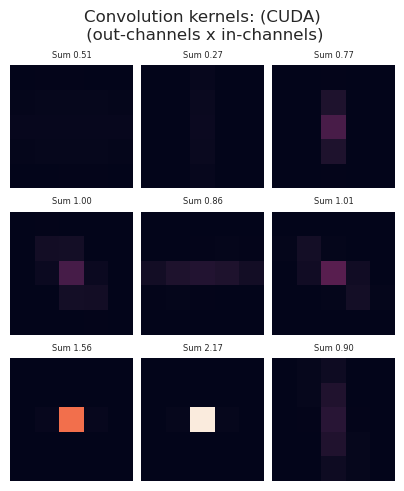

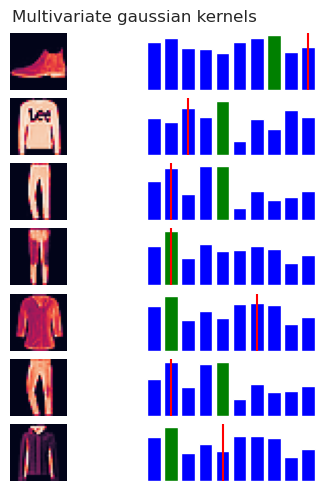

In [28]:
eval_accuracy(cls_multi)
num_params(cls_multi)
plot_model_kernels(cls_multi)
plot_predictions(cls_multi, name="Multivariate gaussian kernels")

In [29]:
def _generic_conv_diff_first(
        first_kernel_cls: type[nn.Module],
        kernel_cls: type[nn.Module],
        conv_cls: type[nn.Module],
        init: str = "normal",
):
    first = True

    def _new(in_channels, out_channels, kernel_size):
        nonlocal first
        cur = first_kernel_cls if first else kernel_cls
        first = False
        return GenericConv2D(
            kernel=cur(in_channels, out_channels, kernel_size, init=init),
            conv=conv_cls(),
        )

    return _new

  0%|          | 0/10 [00:00<?, ?epochs/s]

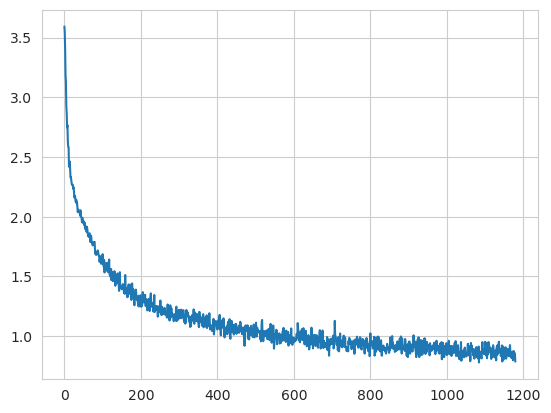

In [30]:
cls_iso_first = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelIso2D, LearnedKernel, LinearConv2D),
    (7, 3, 5),
    (10, 20, 60),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_iso_first, epcohs=10)
plt.plot(hist)

Top1 (train):, 69.7%
Top5 (train):, 97.7%
Top1 (test):, 69.7%
Top5 (test):, 97.5%
32420 parameters


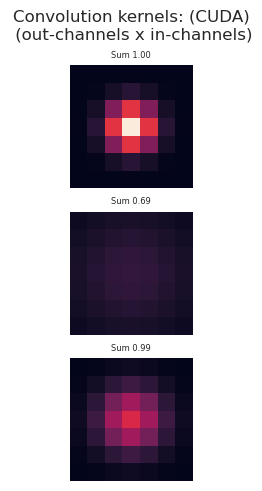

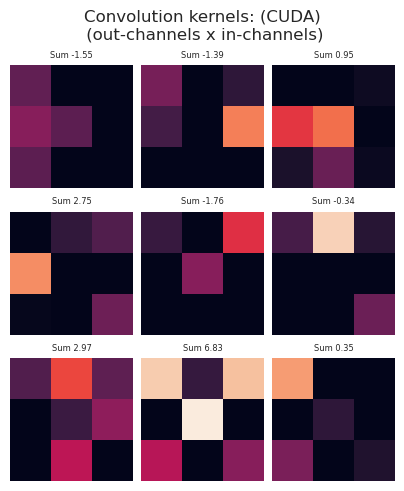

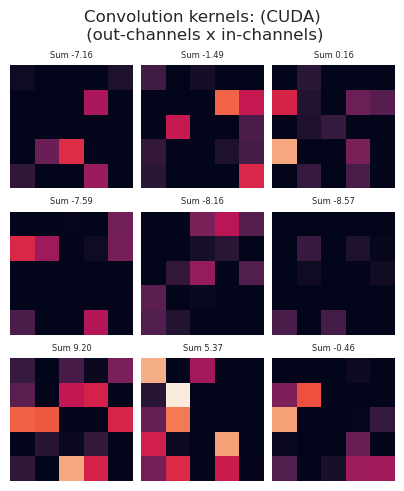

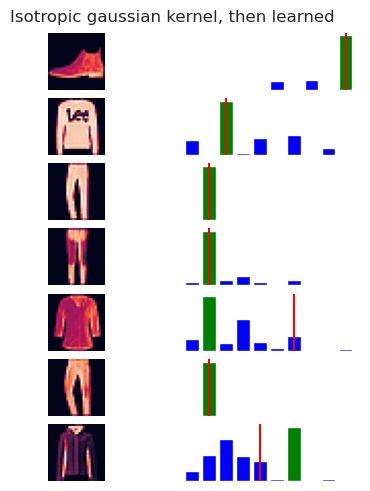

In [31]:
eval_accuracy(cls_iso_first)
num_params(cls_iso_first)
plot_model_kernels(cls_iso_first)
plot_predictions(cls_iso_first, name="Isotropic gaussian kernel, then learned")

  0%|          | 0/20 [00:00<?, ?epochs/s]

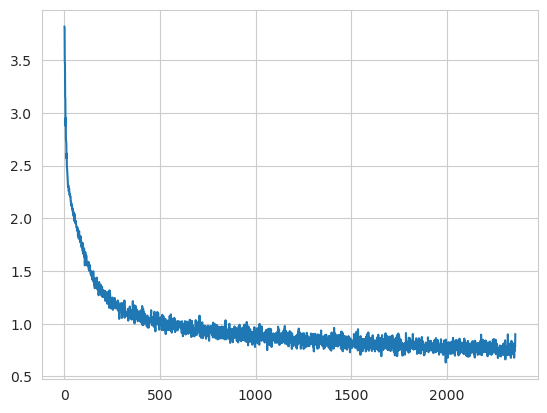

In [32]:
torch.manual_seed(0)
cls_multi_first = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelMulti2D, LearnedKernel, LinearConv2D),
    (7, 3, 5),
    (10, 20, 60),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_multi_first, epcohs=20)
plt.plot(hist)

Top1 (train):, 73.1%
Top5 (train):, 98.3%
Top1 (test):, 72.9%
Top5 (test):, 98.1%
32440 parameters


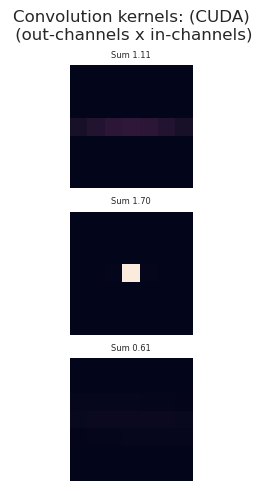

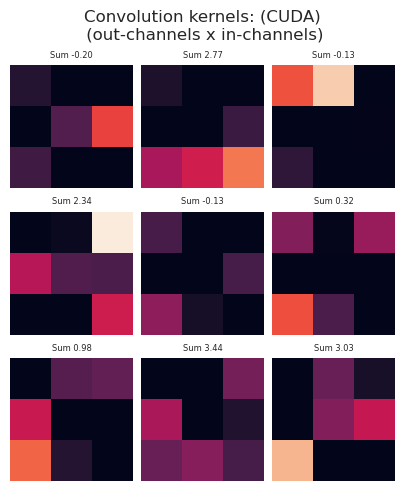

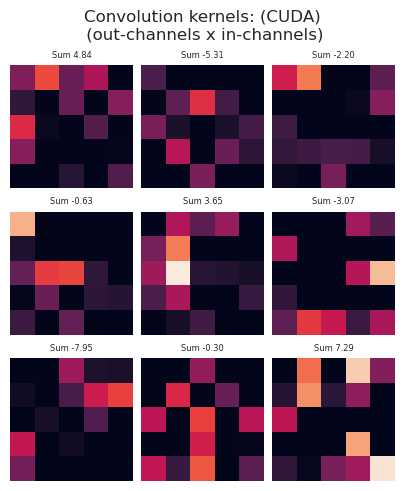

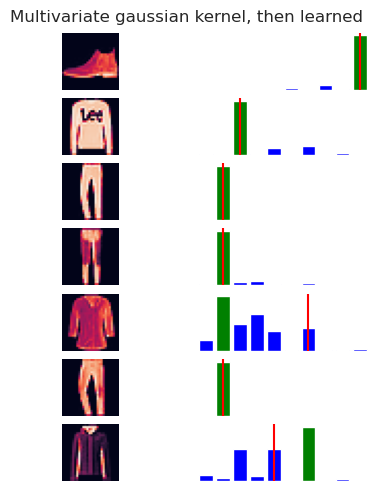

In [33]:
eval_accuracy(cls_multi_first)
num_params(cls_multi_first)
plot_model_kernels(cls_multi_first)
plot_predictions(cls_multi_first, name="Multivariate gaussian kernel, then learned")

  0%|          | 0/20 [00:00<?, ?epochs/s]

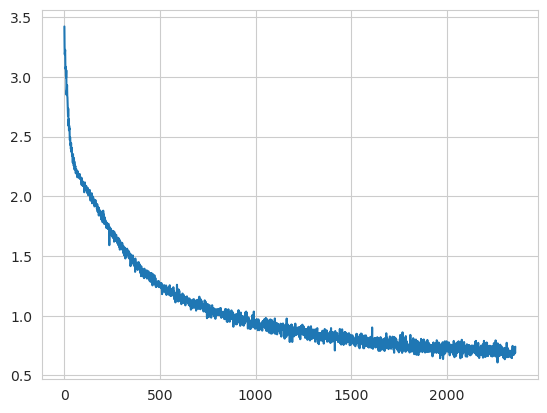

In [34]:
torch.manual_seed(0)
cls_small = SimpleConvClassifier(
    _generic_conv(LearnedKernel, LinearConv2D),
    (7, 3, 3),
    (8, 20, 10),
    out_classes=10,
    img_channels=1,
)
hist = train_model(cls_small, epcohs=20)
plt.plot(hist)

Top1 (train):, 75.0%
Top5 (train):, 99.3%
Top1 (test):, 74.2%
Top5 (test):, 99.1%
3742 parameters


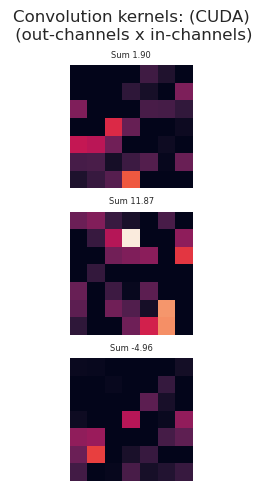

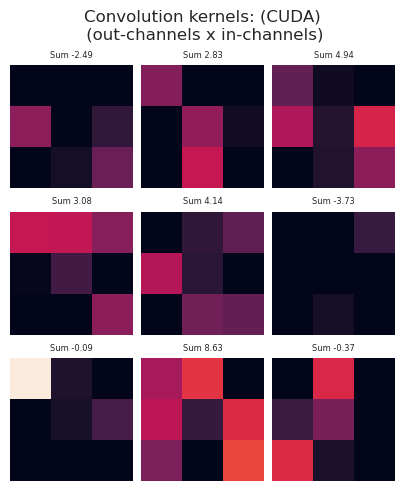

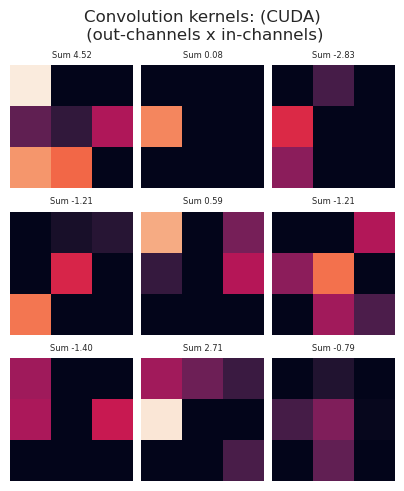

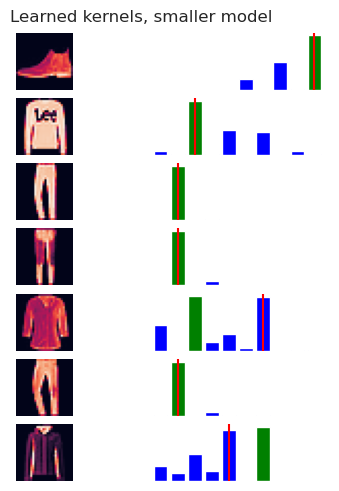

In [35]:
eval_accuracy(cls_small)
num_params(cls_small)
plot_model_kernels(cls_small)
plot_predictions(cls_small, name="Learned kernels, smaller model")

  0%|          | 0/20 [00:00<?, ?epochs/s]

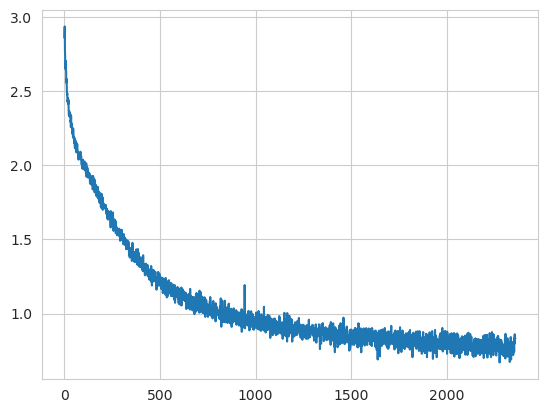

In [36]:
# Same as previous model, but with five (unactivated) scale spaces at the front
torch.manual_seed(0)
cls_small_iso = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelIso2D, LearnedKernel, LinearConv2D),
    (7, 7, 3, 3),
    (5, 8, 20, 10),
    out_classes=10,
    img_channels=1,
    activate_first=False,
)
hist = train_model(cls_small_iso, epcohs=20)
plt.plot(hist)

Top1 (train):, 72.0%
Top5 (train):, 98.7%
Top1 (test):, 71.6%
Top5 (test):, 98.6%
5315 parameters


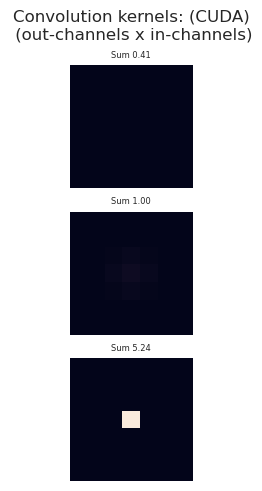

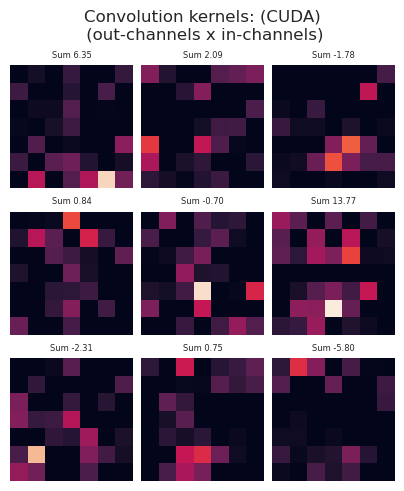

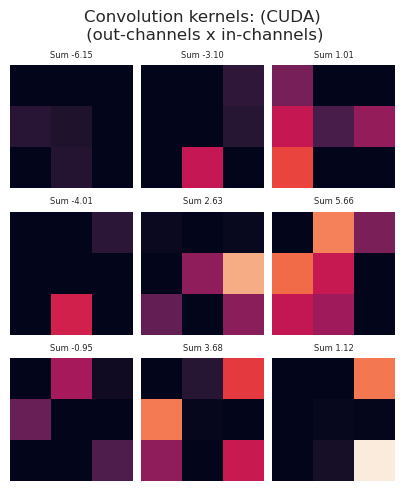

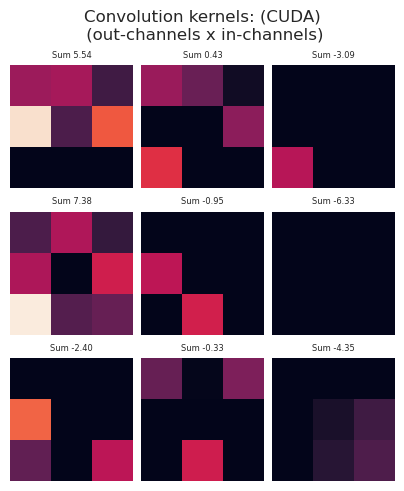

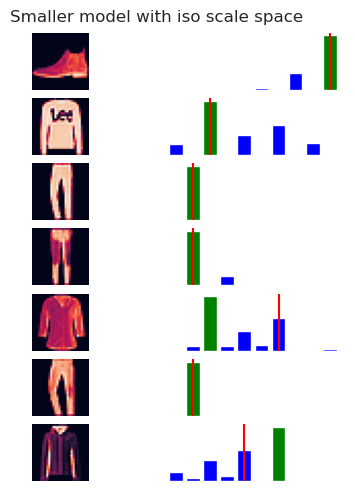

In [37]:
eval_accuracy(cls_small_iso)
num_params(cls_small_iso)
plot_model_kernels(cls_small_iso)
plot_predictions(cls_small_iso, name="Smaller model with iso scale space")

  0%|          | 0/20 [00:00<?, ?epochs/s]

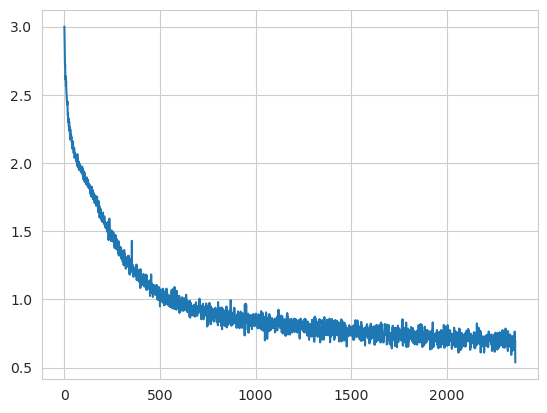

In [38]:
torch.manual_seed(0)
cls_small_multi = SimpleConvClassifier(
    _generic_conv_diff_first(GaussKernelMulti2D, LearnedKernel, LinearConv2D),
    (7, 7, 3, 3),
    (5, 8, 20, 10),
    out_classes=10,
    img_channels=1,
    activate_first=False,
)
hist = train_model(cls_small_multi, epcohs=20)
plt.plot(hist)

Top1 (train):, 73.6%
Top5 (train):, 99.2%
Top1 (test):, 73.0%
Top5 (test):, 98.9%
5325 parameters


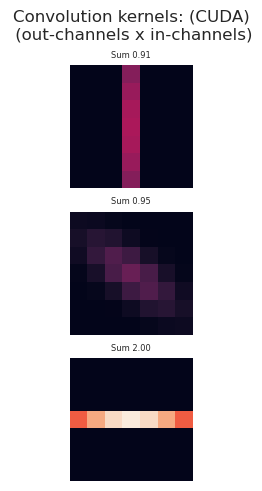

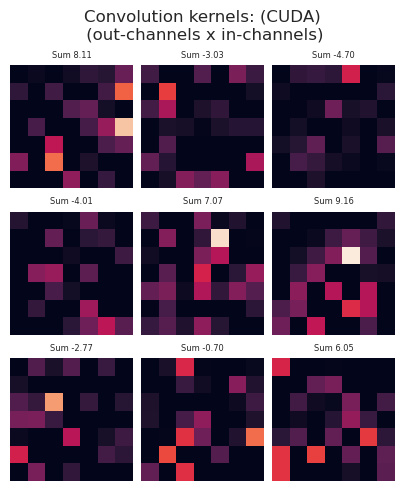

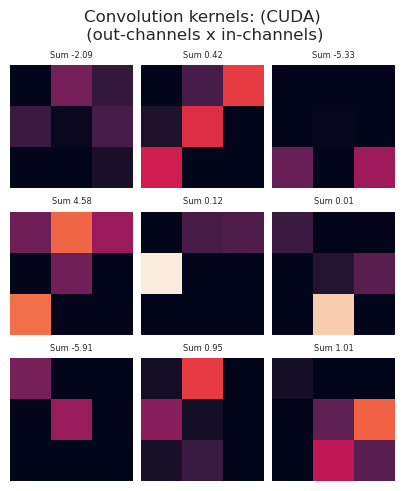

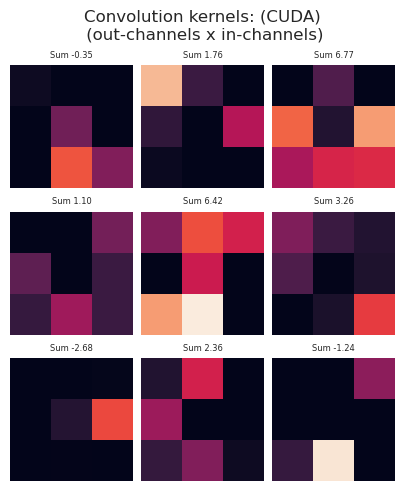

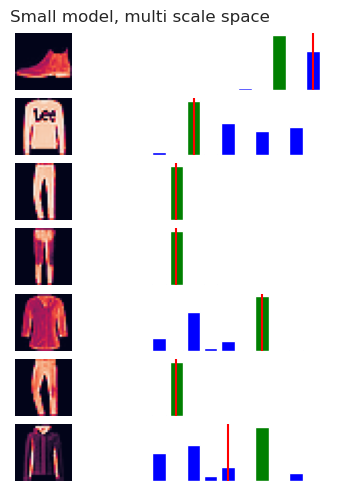

In [39]:
eval_accuracy(cls_small_multi)
num_params(cls_small_multi)
plot_model_kernels(cls_small_multi)
plot_predictions(cls_small_multi, name="Small model, multi scale space")